## 0. Imports

In [2]:
# Standard library imports
import pandas as pd
import numpy as np
import os
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import cv2
import sys
import matplotlib.pyplot as plt

# ML imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Custom imports
# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from classification.ml_logic.preprocessor import Preprocessor

## 1. Data loading

### 1.1 Dataframe loading

In [2]:
bcd_root_dir = Path('../raw_data/breast-cancer-detection')
mini_ddsm_root_dir = Path('../raw_data/MINI-DDSM-Complete-JPEG-8')

# Import breast-cancer-detection dataset
data = []

for split in ['train', 'valid', 'test']:
    split_dir = bcd_root_dir / split
    for label in ['0', '1']:
        label_dir = split_dir / label
        for img_path in label_dir.glob('*.jpg'):
            data.append({
                'image_name': img_path.name,
                'image_path': str(img_path),
                'label': int(label),
                'split': split
            })

bcd_df = pd.DataFrame(data)
print(f'Breast Cancer Detection data loaded successfully. {len(bcd_df)} records found.')

bcd_train_df = bcd_df[bcd_df['split'] == 'train']
bcd_val_df = bcd_df[bcd_df['split'] == 'valid']
bdc_test_df = bcd_df[bcd_df['split'] == 'test']

# Import MINI-DDSM dataset

# Load Excel file
mini_ddsm_df = pd.read_excel(os.path.join(mini_ddsm_root_dir, 'DataWMask.xlsx'))
print(f'Mini-DDSM data loaded successfully. {len(mini_ddsm_df)} records found.')
# print(mini_ddsm_df.head())

# Replace backslashes with forward slashes in fullPath
mini_ddsm_df['fullPath'] = mini_ddsm_df['fullPath'].str.replace('\\', '/', regex=False)
# Ensure fullPath is a string
mini_ddsm_df['fullPath'] = mini_ddsm_df['fullPath'].astype(str)

# Extract patiend ID from fileName (format: C_{patient_id}_1_LATERALITY_VIEW.jpg)
mini_ddsm_df['fileName'] = mini_ddsm_df['fileName'].astype(str).str.strip()
mini_ddsm_df['patient_id'] = mini_ddsm_df['fileName'].str.extract(r'\w_(\d+)_1')

# Binary mapping: Cancer = 1, Benign and Normal = 0
def create_binary_labels(status):
    if status == 'Cancer':
        return 1
    else: # Benign or Normal
        return 0

mini_ddsm_df['binary_label'] = mini_ddsm_df['Status'].apply(create_binary_labels)

# Remove any rows with missing labels
mini_ddsm_df = mini_ddsm_df.dropna(subset=['binary_label', 'patient_id'])
print(f'Final dataset size after removing missing labels: {len(mini_ddsm_df)} records.')

print(f"Total images: {len(mini_ddsm_df)}")
print(f"Total unique patients: {mini_ddsm_df['patient_id'].nunique()}")
print(f"Original class distribution:\n{mini_ddsm_df['Status'].value_counts()}")
print(f"\nBinary class distribution:")
print(f"Non-Cancer (Benign + Normal): {len(mini_ddsm_df[mini_ddsm_df['binary_label'] == 0])}")
print(f"Cancer: {len(mini_ddsm_df[mini_ddsm_df['binary_label'] == 1])}")

Breast Cancer Detection data loaded successfully. 3383 records found.
Mini-DDSM data loaded successfully. 7808 records found.
Final dataset size after removing missing labels: 7808 records.
Total images: 7808
Total unique patients: 1692
Original class distribution:
Status
Cancer    2716
Benign    2684
Normal    2408
Name: count, dtype: int64

Binary class distribution:
Non-Cancer (Benign + Normal): 5092
Cancer: 2716


In [3]:
def patient_based_split(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Split data by patient ID to avoid data leakage.
    Args:
        df (pd.DataFrame): DataFrame containing image data with 'patient_id' and 'Status'.
        train_ratio (float): Proportion of data to use for training.
        val_ratio (float): Proportion of data to use for validation.
        test_ratio (float): Proportion of data to use for testing.
        random_state (int): Random seed for reproducibility.
    Returns:
        tuple: DataFrames for train, validation, and test sets.
    """
    # Get unique patients with their status
    patient_info = df.groupby('patient_id')['Status'].first().reset_index()
    patient_info['binary_label'] = patient_info['Status'].apply(create_binary_labels)

    unique_patients = patient_info['patient_id'].unique()

    # Shuffle patients
    np.random.seed(random_state)
    np.random.shuffle(unique_patients)

    # Calculate split sizes
    total_patients = len(unique_patients)
    train_size = int(train_ratio * total_patients)
    val_size = int(val_ratio * total_patients)

    # Split patient IDs
    train_patients = unique_patients[:train_size]
    val_patients = unique_patients[train_size:train_size+val_size]
    test_patients = unique_patients[train_size+val_size:]

    print(f"\nPatient distribution:")
    print(f"Train patients: {len(train_patients)}")
    print(f"Validation patients: {len(val_patients)}")
    print(f"Test patients: {len(test_patients)}")

    # Assign split labels to all images based on patient ID
    def assign_split(patient_id):
        if patient_id in train_patients:
            return 'train'
        elif patient_id in val_patients:
            return 'val'
        else:
            return 'test'

    df['split'] = df['patient_id'].apply(assign_split)

    # Create separate dataframes
    train_df = df[df['split'] == 'train'].copy()
    val_df = df[df['split'] == 'val'].copy()
    test_df = df[df['split'] == 'test'].copy()

    # Print detailed statistics
    print(f"\nImage distribution:")
    print(f"Train images: {len(train_df)} (Cancer: {sum(train_df['binary_label'])}, Non-Cancer: {len(train_df) - sum(train_df['binary_label'])})")
    print(f"Val images: {len(val_df)} (Cancer: {sum(val_df['binary_label'])}, Non-Cancer: {len(val_df) - sum(val_df['binary_label'])})")
    print(f"Test images: {len(test_df)} (Cancer: {sum(test_df['binary_label'])}, Non-Cancer: {len(test_df) - sum(test_df['binary_label'])})")

    # Verify no patient leakage
    train_patients_set = set(train_df['patient_id'].unique())
    val_patients_set = set(val_df['patient_id'].unique())
    test_patients_set = set(test_df['patient_id'].unique())

    assert len(train_patients_set.intersection(val_patients_set)) == 0, "Patient leakage between train and val!"
    assert len(train_patients_set.intersection(test_patients_set)) == 0, "Patient leakage between train and test!"
    assert len(val_patients_set.intersection(test_patients_set)) == 0, "Patient leakage between val and test!"

    print("✓ No patient leakage detected!")

    return train_df, val_df, test_df

# Execute the split
mini_ddsm_train_df, mini_ddsm_val_df, mini_ddsm_test_df = patient_based_split(mini_ddsm_df)


Patient distribution:
Train patients: 1184
Validation patients: 253
Test patients: 255

Image distribution:
Train images: 5480 (Cancer: 1880, Non-Cancer: 3600)
Val images: 1144 (Cancer: 412, Non-Cancer: 732)
Test images: 1184 (Cancer: 424, Non-Cancer: 760)
✓ No patient leakage detected!


In [4]:
# Create image paths for MINI-DDSM dataset
mini_ddsm_train_df['image_path'] = mini_ddsm_train_df['fullPath'].apply(lambda x: str(mini_ddsm_root_dir / x))
mini_ddsm_val_df['image_path'] = mini_ddsm_val_df['fullPath'].apply(lambda x: str(mini_ddsm_root_dir / x))
mini_ddsm_test_df['image_path'] = mini_ddsm_test_df['fullPath'].apply(lambda x: str(mini_ddsm_root_dir / x))

# Remove unnecessary columns
mini_ddsm_train_df = mini_ddsm_train_df[['fileName', 'image_path', 'binary_label', 'split']]
mini_ddsm_val_df = mini_ddsm_val_df[['fileName', 'image_path', 'binary_label', 'split']]
mini_ddsm_test_df = mini_ddsm_test_df[['fileName', 'image_path', 'binary_label', 'split']]

## Rename columns for consistency
# fileName to image_name
mini_ddsm_train_df.rename(columns={'fileName': 'image_name'}, inplace=True)
mini_ddsm_val_df.rename(columns={'fileName': 'image_name'}, inplace=True)
mini_ddsm_test_df.rename(columns={'fileName': 'image_name'}, inplace=True)
# binary_label to label
mini_ddsm_train_df.rename(columns={'binary_label': 'label'}, inplace=True)
mini_ddsm_val_df.rename(columns={'binary_label': 'label'}, inplace=True)
mini_ddsm_test_df.rename(columns={'binary_label': 'label'}, inplace=True)

#### 1.1.1 Downsampling individual datasets

In [5]:
# breast-cancer-detection dataset downsampling
# Separate majority and minority classes
bcd_train_majority_class = bcd_train_df[bcd_train_df['label'] == 0]
bcd_train_minority_class = bcd_train_df[bcd_train_df['label'] == 1]

# Downsample majority class to match minority class size
bcd_train_majority_downsampled = bcd_train_majority_class.sample(n=len(bcd_train_minority_class), random_state=42)

# Combine minority class with downsampled majority class
bcd_train_balanced = pd.concat([bcd_train_majority_downsampled, bcd_train_minority_class])

# Shuffle the dataset
bcd_train_balanced = bcd_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Original distribution:")
print(bcd_train_df['label'].value_counts())
print("\nBalanced distribution:")
print(bcd_train_balanced['label'].value_counts())

Original distribution:
label
0    1569
1     803
Name: count, dtype: int64

Balanced distribution:
label
0    803
1    803
Name: count, dtype: int64


In [6]:
# mini-ddsm dataset downsampling
# Separate majority and minority classes
mini_ddsm_train_majority_class = mini_ddsm_train_df[mini_ddsm_train_df['label'] == 0]
mini_ddsm_train_minority_class = mini_ddsm_train_df[mini_ddsm_train_df['label'] == 1]

# Downsample majority class to match minority class size
mini_ddsm_train_majority_downsampled = mini_ddsm_train_majority_class.sample(n=len(mini_ddsm_train_minority_class), random_state=42)

# Combine minority class with downsampled majority class
mini_ddsm_train_balanced = pd.concat([mini_ddsm_train_majority_downsampled, mini_ddsm_train_minority_class])

# Shuffle the dataset
mini_ddsm_train_balanced = mini_ddsm_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Original distribution:")
print(mini_ddsm_train_df['label'].value_counts())
print("\nBalanced distribution:")
print(mini_ddsm_train_balanced['label'].value_counts())

Original distribution:
label
0    3600
1    1880
Name: count, dtype: int64

Balanced distribution:
label
0    1880
1    1880
Name: count, dtype: int64


#### 1.1.1 Changing and combining dataframes

In [7]:
# Combine datasets
combined_train_df = pd.concat([bcd_train_balanced, mini_ddsm_train_balanced], ignore_index=True)
combined_val_df = pd.concat([bcd_val_df, mini_ddsm_val_df], ignore_index=True)
combined_test_df = pd.concat([bdc_test_df, mini_ddsm_test_df], ignore_index=True)

print(f"\nCombined dataset sizes:")
print(f"Train set: {len(combined_train_df)}")
print(f"Validation set: {len(combined_val_df)}")
print(f"Test set: {len(combined_test_df)}")
print(f'\nCombined class distribution in train set:')
print(combined_train_df['label'].value_counts())
print(f'\nCombined class distribution in validation set:')
print(combined_val_df['label'].value_counts())
print(f'\nCombined class distribution in test set:')
print(combined_test_df['label'].value_counts())


Combined dataset sizes:
Train set: 5366
Validation set: 1819
Test set: 1520

Combined class distribution in train set:
label
0    2683
1    2683
Name: count, dtype: int64

Combined class distribution in validation set:
label
0    1180
1     639
Name: count, dtype: int64

Combined class distribution in test set:
label
0    968
1    552
Name: count, dtype: int64


### 1.2 Image loading and preprocessing function

In [8]:
combined_train_df.head()

,image_name,image_path,label,split
0,1660_312382431_png.rf.60f10fd25f27eba500354c40...,../raw_data/breast-cancer-detection/train/0/16...,0,train
1,37032_1243050806_png.rf.733846bab2dde1d3137703...,../raw_data/breast-cancer-detection/train/1/37...,1,train
2,2472_1387239105_png.rf.d2ad3d9ff1876a30491933e...,../raw_data/breast-cancer-detection/train/0/24...,0,train
3,259_391410545_png.rf.f42b7e4e7c60e8113d12ff5c8...,../raw_data/breast-cancer-detection/train/0/25...,0,train
4,2066_1080373862_png.rf.a63e0a6f7806827934bda38...,../raw_data/breast-cancer-detection/train/0/20...,0,train


In [9]:
def load_data_concurrently(df, preprocess_image_func, max_workers=4):
    """
    Load images concurrently using ThreadPoolExecutor.
    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
        preprocess_image_func (function): Function to preprocess images.
        max_workers (int): Number of threads to use.
    Returns:
        tuple: Numpy arrays of images and labels.
    """
    images = []
    labels = []

    def process_row(row):
        img_path = row['image_path']
        if os.path.exists(img_path):
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            processed_image = preprocess_image_func(image)
            return processed_image, row['label']
        else:
            print(f"Warning: Image not found at {img_path}")
            return None

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_row, row) for _, row in df.iterrows()]
        for future in futures:
            result = future.result()
            if result is not None:
                img, label = result
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

In [10]:
preproc = Preprocessor()

## 2. Model training and evaluation functions

### 2.1 Model training functions

In [ ]:
def create_model(input_shape=(224, 224, 3)):
    # Base model with pre-trained weights
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # Freeze first 75% of layers
    # num_layers = len(base_model.layers)
    # freeze_up_to = int(num_layers * 0.75)  # Calculate 75% cutoff
    # for layer in base_model.layers[:freeze_up_to]:
    #     layer.trainable = False  # Freeze individual layers
    base_model.trainable = False

    # Explicitly define inputs and pass training=False for batch norm
    inputs = base_model.input
    x = base_model(inputs, training=False)  # Critical for batch norm handling[1][4]

    # Existing top layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=3e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', "precision", "recall", 'AUC']
    )
    return model

In [ ]:
from tensorflow.keras.applications import VGG19  # Changed import

def create_model_vgg19(input_shape=(224, 224, 3)):
    # Base model with pre-trained weights
    base_model = VGG19(  # Changed to VGG19
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = False

    # Build model
    inputs = base_model.input
    x = base_model(inputs)  # Removed training=False (not needed for VGG19)

    # Adjusted top layers for VGG19
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Increased from 128 to 256
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)  # Additional layer
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),  # Reduced learning rate
        loss='binary_crossentropy',
        metrics=['accuracy', "precision", "recall", 'AUC']
    )
    return model


In [5]:
model_test = create_model_vgg19()
model_test.summary()

2025-06-18 16:55:45.881962: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-18 16:55:45.882064: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-18 16:55:45.882108: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-18 16:55:45.882493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-18 16:55:45.882638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,188,737 (77.01 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [6]:
def train_mammography_classifier(train_df, val_df, test_df,
                                 preprocess_image_func,
                                 epochs=100,
                                 use_callbacks=True,
                                 use_data_augmentation=False):
    """
    Complete binary classification training pipeline with patient-based splits
    Args:
        train_df (pd.DataFrame): DataFrame for training set.
        val_df (pd.DataFrame): DataFrame for validation set.
        test_df (pd.DataFrame): DataFrame for test set.
        preprocess_image_func (function): Function to preprocess images.
    Returns:
        tuple: Trained model, training history, and test data.
    """
    # Load and preprocess data for each split
    print("Loading and preprocessing images...")
    X_train, y_train = load_data_concurrently(train_df, preprocess_image_func)
    X_val, y_val = load_data_concurrently(val_df, preprocess_image_func)
    X_test, y_test = load_data_concurrently(test_df, preprocess_image_func)

    print(f"Training samples: {len(X_train)} with {sum(y_train == 0)} non-cancer images and {sum(y_train == 1)} cancer images.")
    print(f"Validation samples: {len(X_val)} with {sum(y_val == 0)} non-cancer images and {sum(y_val == 1)} cancer images.")
    print(f"Test samples: {len(X_test)} with {sum(y_test == 0)} non-cancer images and {sum(y_test == 1)} cancer images.")

    # Create and compile model
    input_shape = X_train.shape[1:]
    model = create_model_vgg19(input_shape)

    print("\nModel Summary:")
    model.summary()

    # Data augmentation
    datagen = ImageDataGenerator(rotation_range=15,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.1,
                                 horizontal_flip=True,
                                 fill_mode='nearest'
                                 )

    # Callbacks
    es = EarlyStopping(
        monitor='val_AUC',
        patience=10,
        verbose=1,
        mode = 'max',
        restore_best_weights=True
    )

    plateau = ReduceLROnPlateau(
        monitor='val_AUC',
        factor=0.5,
        patience=3,
        verbose=1,
        mode='max',
        min_lr=0.000001
    )

    if use_callbacks:
        callbacks = [es, plateau]
    else:
        callbacks = None

    # Training with 4-fold validation strategy
    print("Starting training...")
    if use_data_augmentation:
        train_generator = datagen.flow(X_train, y_train, batch_size=64)
        steps_per_epoch = len(X_train) // 64
        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            validation_data=(X_val, y_val),
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
    else:
        history = model.fit(
            X_train, y_train,
            batch_size=64,
            validation_data=(X_val, y_val),
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )

    return model, history, X_train, y_train, X_val, y_val, X_test, y_test

### 2.2 Model evalution function

In [7]:
def evaluate_final_model(model, X_test, y_test):
    """
    Evaluate the trained model on the test set
    Args:
        model (tf.keras.Model): Trained model.
        X_test (np.ndarray): Test images.
        y_test (np.ndarray): Test labels.
    Returns:
        None
    """
    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Print classification report
    print("\nFinal Test Set Evaluation:")
    print("="*50)
    target_names = ['Non-Cancer (Benign+Normal)', 'Cancer']
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Calculate medical metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for cancer detection
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall for non-cancer detection
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

    print(f"\nMedical Performance Metrics:")
    print(f"Sensitivity (Cancer Detection Rate): {sensitivity:.3f}")
    print(f"Specificity (Non-Cancer Detection Rate): {specificity:.3f}")
    print(f"Positive Predictive Value (PPV): {ppv:.3f}")
    print(f"Negative Predictive Value (NPV): {npv:.3f}")


## 3. Model training and evaluation

In [16]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Loading and preprocessing images...
Training samples: 5366 with 2683 non-cancer images and 2683 cancer images.
Validation samples: 1819 with 1180 non-cancer images and 639 cancer images.
Test samples: 1520 with 968 non-cancer images and 552 cancer images.

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,188,737 (77.01 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Starting training...
Epoch 1/50


2025-06-18 09:51:51.263307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


84/84 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - AUC: 0.4741 - accuracy: 0.4753 - loss: 0.9110 - precision: 0.4793 - recall: 0.4917 - val_AUC: 0.5200 - val_accuracy: 0.5646 - val_loss: 0.6883 - val_precision: 0.3554 - val_recall: 0.2942 - learning_rate: 1.0000e-04
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - AUC: 0.4904 - accuracy: 0.4788 - loss: 0.8620 - precision: 0.4899 - recall: 0.4838 - val_AUC: 0.5215 - val_accuracy: 0.5607 - val_loss: 0.6878 - val_precision: 0.3485 - val_recall: 0.2879 - learning_rate: 1.0000e-04
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - AUC: 0.4928 - accuracy: 0.4940 - loss: 0.8464 - precision: 0.4958 - recall: 0.4778 - val_AUC: 0.5185 - val_accuracy: 0.5250 - val_loss: 0.6959 - val_precision: 0.3560 - val_recall: 0.4351 - learning_rate: 1.0000e-04
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - AUC: 0.5082 - accuracy: 0.4964 - loss: 0.8175 - precision: 0.5035 - recall: 0.4956 - val_AUC: 0.5176 - val_accuracy: 0.5536 - val_loss: 0.6904 - val_pr

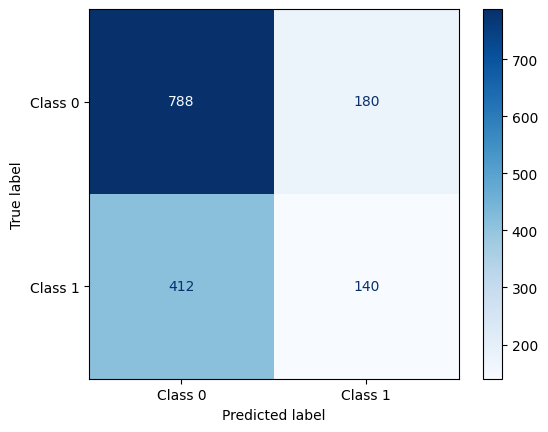


Medical Performance Metrics:
Sensitivity (Cancer Detection Rate): 0.254
Specificity (Non-Cancer Detection Rate): 0.814
Positive Predictive Value (PPV): 0.438
Negative Predictive Value (NPV): 0.657


In [17]:
model, history, X_train, y_train, X_val, y_val, X_test, y_test = train_mammography_classifier(
    combined_train_df,
    combined_val_df,
    combined_test_df,
    preprocess_image_func=preproc.preprocess_image,
    epochs=50,
    use_callbacks=True,
    use_data_augmentation=False
)

evaluate_final_model(model, X_test, y_test)

## Try #2 (with data augmentation)

In [ ]:
def train_mammography_classifier_2(X_train, y_train, X_val, y_val,
                                 epochs=100,
                                 use_callbacks=True,
                                 use_data_augmentation=False):
    """
    Complete binary classification training pipeline with patient-based splits
    Args:
        X_train (np.ndarray): Training images.
        y_train (np.ndarray): Training labels.
        X_val (np.ndarray): Validation images.
        y_val (np.ndarray): Validation labels.
        epochs (int): Number of training epochs.
        use_callbacks (bool): Whether to use callbacks during training.
        use_data_augmentation (bool): Whether to apply data augmentation.
    Returns:
        tuple: Trained model, training history
    """

    # Create and compile model
    input_shape = X_train.shape[1:]
    model = create_model_vgg19(input_shape)

    print("\nModel Summary:")
    model.summary()

    # Data augmentation
    datagen = ImageDataGenerator(rotation_range=15,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.1,
                                 horizontal_flip=True,
                                 fill_mode='nearest'
                                 )

    # Callbacks
    es = EarlyStopping(
        monitor='val_AUC',
        patience=10,
        verbose=1,
        mode = 'max',
        restore_best_weights=True
    )

    plateau = ReduceLROnPlateau(
        monitor='val_AUC',
        factor=0.5,
        patience=3,
        verbose=1,
        mode='max',
        min_lr=0.000001
    )

    if use_callbacks:
        callbacks = [es, plateau]
    else:
        callbacks = None

    # Training with 4-fold validation strategy
    print("Starting training...")
    if use_data_augmentation:
        train_generator = datagen.flow(X_train, y_train, batch_size=64)
        steps_per_epoch = len(X_train) // 64
        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            validation_data=(X_val, y_val),
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
    else:
        history = model.fit(
            X_train, y_train,
            batch_size=64,
            validation_data=(X_val, y_val),
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )

    return model, history

In [ ]:
model_2, history_2 = train_mammography_classifier_2(
    X_train, y_train,
    X_val, y_val,
    epochs=50,
    use_callbacks=True,
    use_data_augmentation=False
)

evaluate_final_model(model_2, X_test, y_test)


Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,188,737 (77.01 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Starting training...
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - AUC: 0.4975 - accuracy: 0.4908 - loss: 0.9455 - precision: 0.4930 - recall: 0.5352 - val_AUC: 0.4686 - val_accuracy: 0.3513 - val_loss: 0.7530 - val_precision: 0.3513 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - AUC: 0.4987 - accuracy: 0.4954 - loss: 0.9060 - precision: 0.4952 - recall: 0.4920 - val_AUC: 0.4695 - val_accuracy: 0.3480 - val_loss: 0.7319 - val_precision: 0.3488 - val_recall: 0.9875 - learning_rate: 1.0000e-04
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - AUC: 0.4894 - accuracy: 0.4911 - loss: 0.8945 - precision: 0.4927 - recall: 0.4965 - val_AUC: 0.4750 - val_accuracy: 0.3513 - val_loss: 0.7779 - val_precision: 0.3513 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 408s 5s/step - AUC: 0.5099 - accuracy: 0.4989 - loss: 0.8671 - precision: 0.4942 - recall: 0.5238 - val_AUC: 0.4794 - val_accuracy: 0.

## 4. RSNA data

In [ ]:
# Load data
X_train_1 = np.load('../raw_data/RSNA_full/X_train_1.npy')
# X_train_2 = np.load('../raw_data/RSNA_full/X_train_2.npy')
# X_train_3 = np.load('../raw_data/RSNA_full/X_train_3.npy')
# X_train_4 = np.load('../raw_data/RSNA_full/X_train_4.npy')
X_val_1 = np.load('../raw_data/RSNA_full/X_val_1.npy')

# X_train = np.concatenate([X_train_1, X_train_2, X_train_3], axis=0)
X_val = X_val_1

y_train_1 = np.load('../raw_data/RSNA_full/y_train_1.npy')
# y_train_2 = np.load('../raw_data/RSNA_full/y_train_2.npy')
# y_train_3 = np.load('../raw_data/RSNA_full/y_train_3.npy')
# y_train_4 = np.load('../raw_data/RSNA_full/y_train_4.npy')
y_val_1 = np.load('../raw_data/RSNA_full/y_val_1.npy')
# y_train = np.concatenate([y_train_1, y_train_2, y_train_3], axis=0)
y_val = y_val_1

In [ ]:
# Train the model
model_3, history_3 = train_mammography_classifier_2(
    X_train, y_train,
    X_val, y_val,
    epochs=50,
    use_callbacks=True,
    use_data_augmentation=False
)

evaluate_final_model(model_3, X_train_4, y_train_4)